# %% [markdown]

 ## Continuation ParaScope.


# %% [markdown]

 Install necessary packages for transformer models and evaluation metrics.
 Just run and continue unless there are errors.
 you may need to install some packages:

In [ ]:
# %%

# !pip install -q transformer-lens plotly pandas matplotlib seaborn numpy scikit-learn datasets transformers sentence-transformers

from transformer_lens import HookedTransformer
import torch
import torch.nn as nn
import einops
from typing import Callable
from jaxtyping import Float
from torch import Tensor
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformerConfig
torch.set_grad_enabled(False)

# %% [markdown]

 # Continuation ParaScope Implementation

 ParaScope (Paragraph Scope) is a method for extracting paragraph-level information from language model residual streams.
 The core idea is to decode what a language model is "planning" to write in an upcoming paragraph by analyzing the
 residual stream activations at transition points (like "\n\n" tokens).

 ![ParaScope Illustration](https://39669.cdn.cke-cs.com/rQvD3VnunXZu34m86e5f/images/7421b220f111e4736b9a8d5a7bae0d0267d1b321fbda5461.png)

 **Continuation ParaScope** is the simplest approach:
 1. Extract residual stream activations at a "\n\n" token from some original text
 2. Create a minimal prompt with just "<bos>\n\n"
 3. Replace the residual activations of the "\n\n" token with the saved activations
 4. Generate text to see what the model "planned" to write

 This tests whether language models encode information about upcoming paragraphs in their residual streams,
 providing evidence for either explicit or implicit planning in language generation.


 ![Continuation Parascope Illustration](https://39669.cdn.cke-cs.com/rQvD3VnunXZu34m86e5f/images/bb0725d6fb774228484beadd06dd8af5185f7c7d539b7090.png)


# %% [markdown]

 ## Setup and Installation

 We start by loading the model and tokenizer.

In [ ]:
# %%

model = HookedTransformer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")

# print("Available hook points:")
# for name in list(model.hook_dict.keys())[:28]:  # Show first few hook points
#     print(name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.2-3B-Instruct into HookedTransformer


# %% [markdown]

 ### Prompting and relevant scaffolding
 Some functions to help with prompting

In [ ]:
# %%

def format_prompt(prompt: str) -> torch.Tensor:
    """
    Create tokenized chat using the model's tokenizer with chat template.
    """
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Apply chat template and tokenize
    return model.tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

def two_topics_prompt(topic1: str, topic2: str) -> torch.Tensor:
    prompt = f"""
Please write two paragraphs, each of length 2 sentences. The first should describe {topic1}, and the second should describe {topic2}. Do not say explicitly name the topic, and do not say anything else.
"""
    return format_prompt(prompt)

def extract_second_paragraph(text: str) -> str:
    return text.split("\n\n")[1]

# %% [markdown]

 ### Baseline Generation
 Try running the model with just the prompt to get a baseline.

In [ ]:
# %%

prompt = two_topics_prompt("monster trucks", "paracetamol")
prompt_tokens = model.to_tokens(prompt)[:, 1:] # remove double <bos>

# Generate context based on the string
baseline_generated_tokens = model.generate(prompt_tokens, max_new_tokens=200, do_sample=True, temperature=0.3)
output_tokens = baseline_generated_tokens[:, len(prompt_tokens[0]):]
output_str_tokens = model.to_str_tokens(output_tokens)
print(model.to_str_tokens(prompt_tokens))
print(output_str_tokens)

# get first paragraph
# Find the index of the first occurrence of '\n\n' in the output tokens
index_of_first_newline = None
for i, token in enumerate(output_str_tokens):
    if '\n\n' in token:
        index_of_first_newline = i
        break

assert index_of_first_newline is not None
print(f"Index of first newline: {index_of_first_newline} ({[output_str_tokens[index_of_first_newline]]})")

par1_tokens = output_tokens[:, :index_of_first_newline+1]
par2_tokens = output_tokens[:, index_of_first_newline+1:]
par1_str = model.to_string(par1_tokens)[0]
par2_str = model.to_string(par2_tokens)[0]
prompt_with_par1 = torch.cat((prompt_tokens, par1_tokens), dim=-1)
print(par1_str)
print(par2_str)

  0%|          | 0/200 [00:00<?, ?it/s]

['<|begin_of_text|>', '<|start_header_id|>', 'system', '<|end_header_id|>', '\n\n', 'Cut', 'ting', ' Knowledge', ' Date', ':', ' December', ' ', '202', '3', '\n', 'Today', ' Date', ':', ' ', '15', ' Jul', ' ', '202', '5', '\n\n', '<|eot_id|>', '<|start_header_id|>', 'user', '<|end_header_id|>', '\n\n', 'Please', ' write', ' two', ' paragraphs', ',', ' each', ' of', ' length', ' ', '2', ' sentences', '.', ' The', ' first', ' should', ' describe', ' monster', ' trucks', ',', ' and', ' the', ' second', ' should', ' describe', ' par', 'acet', 'am', 'ol', '.', ' Do', ' not', ' say', ' explicitly', ' name', ' the', ' topic', ',', ' and', ' do', ' not', ' say', ' anything', ' else', '.', '<|eot_id|>', '<|start_header_id|>', 'assistant', '<|end_header_id|>', '\n\n']
['G', 'iant', ' vehicles', ' with', ' oversized', ' tires', ' and', ' powerful', ' engines', ' dominate', ' the', ' landscape', ',', ' crushing', ' cars', ' and', ' other', ' obstacles', ' with', ' ease', '.', ' These', ' massive',

# %% [markdown]

 Define the hooks that we'll use to capture the activations

 We'll use the `store_hook` method to store the activations, and the `modify_hook` method to modify the activations.

 The `modify_hook` method is given the activation and the hook, and should return the modified activation only if the hook has not been seen before. (this prevents the scenario where you keep getting the same output over and over)
 We can optionally scale the changed activations by multiplying by a scalar modify_scaling_factor.

In [ ]:
class ActStore:
    def __init__(self, model: HookedTransformer):
        self.act_store = {}
        self.act_seen = set()

        chosen_hooks = ['hook_resid_pre', 'hook_resid_mid']
        Ls = range(model.cfg.n_layers) # all layers, you can test with fewer layers
        self.chosen_hook_list = \
            [f'blocks.{i}.{h}' for h in chosen_hooks for i in Ls]
        self.modify_scaling_factor = 1.0
        self.modify_hook_token_idx = -1

    def store_hook(self, act, hook):
        """
        Store the activations for the given hook, based on the hook name.
        """
        # [your implementation here]
        self.act_store[hook.name] = act.clone()
        return act

    def modify_hook(self, act, hook):
        """
        Modify the activations for the given hook at modify_hook_token_idx, based on the hook name. Optionally scale the source activations by modify_scaling_factor.
        """
        # should we modify the act, or have we already done so?
        if hook.name in self.act_seen:
            return act
        self.act_seen.add(hook.name)

        # modify the act
        # [your implementation here]
        source_act = self.act_store[hook.name]
        idx = self.modify_hook_token_idx
        scale = self.modify_scaling_factor
        act[:, idx, :] = source_act[:, -1, :] * scale
        return act

    def modify_hook_list(self):
        "return a list of hooks to modify, and reset the act_seen set to empty"
        self.act_seen = set()
        return [(hook, self.modify_hook) for hook in self.chosen_hook_list]

    def store_hook_list(self):
        "return a list of hooks to store"
        return [(hook, self.store_hook) for hook in self.chosen_hook_list]

act_store = ActStore(model)

# %% [markdown]

 ## Generate with transferred activations.
 This technique demonstrates "activation patching" or "activation transfer" - a method for transferring learned context from one prompt to another by manipulating the model's internal representations.

 The process works as follows:
 1. Run the model on a "source" prompt that contains rich context (e.g., a paragraph with specific style/content)
 2. Store the intermediate activations (residual stream values) from all the layers for the token of interest on the source prompt
 3. Run the model on a "target" prompt that lacks context (e.g., just "\n\n")
 4. During the target generation, replace the activations at the same positions with the stored activations from the source
 5. This allows the model to generate text as if it had the original context, even though the target prompt is minimal

 This technique reveals how much contextual information is encoded in the model's intermediate representations
 and can be used to study how different types of context (style, topic, format) are stored and utilized.
 Get the full string (example + generated text)

In [ ]:
def transfer_activations(tokens: torch.Tensor, num_copies: int = 10, num_tokens: int = 30):
    """
    Function that:
    - runs the model once with the original prompt, with hooks to save the activations
    - Creates a new prompt with "\n\n" repeated num_copies times
    - then runs the model again with the new prompt, with hooks modifying the activations at the final token to match the original, ang generates many tokens.

    """

    # [your implementation here]
    # Save original activations
    with model.hooks(fwd_hooks=act_store.store_hook_list()):
        logits = model(tokens, return_type="logits")

    # create prompt
    new_str = "\n\n"
    new_tokens = model.to_tokens([new_str for _ in range(num_copies)])

    # Run with hooks again to modify activations of attention output
    with model.hooks(fwd_hooks=act_store.modify_hook_list()):
        new_generated_tokens = model.generate(new_tokens, max_new_tokens=num_tokens, do_sample=True, temperature=0.3)

    return new_generated_tokens

# %% [markdown]

 ## Demonstrating Activation Transfer

 Now we'll test our activation transfer function on different prompts to see how well it preserves
 and transfers contextual information. We'll run the function on:
 1. The original single paragraph prompt to see how it continues the established style/content
 2. The two-paragraph prompt to observe how it handles more complex context transfer

 Each test will generate multiple continuations to show the consistency and variability of the transfer.
 try for paragraph 1

In [ ]:
par1_continued_tokens = transfer_activations(prompt_tokens)
for tok in par1_continued_tokens:
    print(model.to_str_tokens(tok))

# try for paragraph 2
par2_continued_tokens = transfer_activations(prompt_with_par1)
for tok in par2_continued_tokens:
    print(model.to_str_tokens(tok))

  0%|          | 0/30 [00:00<?, ?it/s]

['<|begin_of_text|>', '\n\n', 'These', ' vehicles', ' are', ' designed', ' to', ' withstand', ' the', ' harsh', ' conditions', ' of', ' the', ' desert', ',', ' with', ' reinforced', ' bodies', ' and', ' specialized', ' tires', ' that', ' can', ' handle', ' the', ' extreme', ' temperatures', ' and', ' rocky', ' terrain', '.', ' Their']
['<|begin_of_text|>', '\n\n', 'G', 'iant', ',', ' ancient', ' trees', ' stretch', ' towards', ' the', ' sky', ',', ' their', ' gn', 'ar', 'led', ' branches', ' twisted', ' and', ' tangled', ' in', ' a', ' dance', ' of', ' nature', "'s", ' art', 'istry', '.', ' The', ' rust', 'ling']
['<|begin_of_text|>', '\n\n', 'G', 'iant', ' metal', ' beasts', ' roam', ' the', ' land', ',', ' their', ' thunder', 'ous', ' ro', 'ars', ' echoing', ' through', ' the', ' valleys', ' and', ' their', ' massive', ' strides', ' shaking', ' the', ' earth', '.', ' These', ' mechanical', ' mon', 'st', 'ros']
['<|begin_of_text|>', '\n\n', 'These', ' vehicles', ' are', ' equipped', '

  0%|          | 0/30 [00:00<?, ?it/s]

['<|begin_of_text|>', '\n\n', 'A', ' small', ' dose', ' of', ' the', ' medication', ' can', ' be', ' effective', ' in', ' allev', 'iating', ' symptoms', ',', ' but', ' a', ' larger', ' dose', ' can', ' have', ' severe', ' side', ' effects', '.', ' The', ' dosage', ' must', ' be', ' carefully', ' calculated']
['<|begin_of_text|>', '\n\n', 'A', ' small', ',', ' white', ' pill', ' with', ' a', ' distinctive', ' shape', ' and', ' a', ' bitter', ' taste', ',', ' often', ' accompanied', ' by', ' a', ' strong', ' feeling', ' of', ' nausea', ',', ' d', 'izziness', ',', ' and', ' anxiety', '.', ' Can']
['<|begin_of_text|>', '\n\n', 'A', ' medication', ' is', ' a', ' substance', ' that', ' is', ' designed', ' to', ' treat', ' or', ' prevent', ' a', ' medical', ' condition', ',', ' and', ' it', ' can', ' be', ' used', ' to', ' alleviate', ' symptoms', ',', ' cure', ' a', ' disease', ',', ' or']
['<|begin_of_text|>', '\n\n', 'A', ' small', ',', ' white', ' pill', ' with', ' a', ' distinctive', ' s

# %% [markdown]

 What do you see?
 You should see that the transfered activations give *some* indicaiton of what the model was planning to write, but that they are far from perfect. It seems like the model can guess the next few words, and can sometimes bootstrap from there, but often fails to.
 Can we evaluate this more automatically?

# %% [markdown]

 # Measuring the quality of the continuations.
 We use semantic text embeddings to measure how well our continuation ParaScope technique works.
 Semantic embeddings convert text into high-dimensional vectors that capture meaning - texts with
 similar meanings will have vectors that point in similar directions (high cosine similarity).

 Our evaluation process:
 1. Encode both the original paragraph and the generated continuation into embedding vectors
 2. Calculate cosine similarity between these vectors (ranges from -1 to 1, where 1 = identical meaning)
 3. Higher similarity scores indicate that the continuation successfully captured the semantic content
    that the model was "planning" to write in the original context

 This helps us quantify whether activation transfer preserves meaningful contextual information
 or just produces random text that happens to follow the same format.

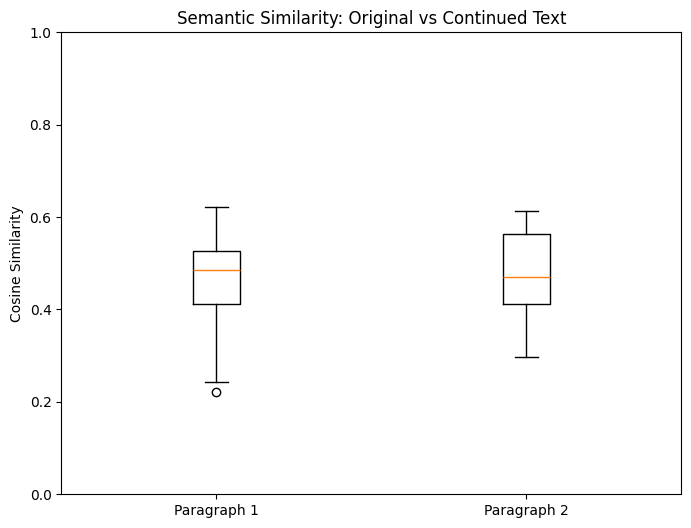

Paragraph 1 mean similarity: 0.454
Paragraph 2 mean similarity: 0.471


In [ ]:
# %%

import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Load evaluation model
sentence_model = SentenceTransformer('all-mpnet-base-v2')

def calculate_similarities(original_text, continued_tokens):
    """Calculate cosine similarities between original and continued text."""
    similarities = []

    for cont_tokens in continued_tokens:
        cont_text = ''.join(model.to_str_tokens(cont_tokens))

        # Calculate cosine similarity
        if original_text and cont_text:
            # [your implementation here]
            orig_embedding = sentence_model.encode(original_text)
            cont_embedding = sentence_model.encode(cont_text)

            cosine_sim = np.dot(orig_embedding, cont_embedding) / (
                np.linalg.norm(orig_embedding) * np.linalg.norm(cont_embedding)
            )
            similarities.append(float(cosine_sim))

    return similarities

# Calculate similarities for both paragraphs
par1_similarities = calculate_similarities(par1_str, par1_continued_tokens)
par2_similarities = calculate_similarities(par2_str, par2_continued_tokens)

# Create comparison graph
fig, ax = plt.subplots(figsize=(8, 6))
box_data = [par1_similarities, par2_similarities]
bp = ax.boxplot(box_data)
ax.set_xticklabels(['Paragraph 1', 'Paragraph 2'])
ax.set_ylabel('Cosine Similarity')
ax.set_title('Semantic Similarity: Original vs Continued Text')
ax.set_ylim(0, 1)
plt.show()

print(f"Paragraph 1 mean similarity: {np.mean(par1_similarities):.3f}")
print(f"Paragraph 2 mean similarity: {np.mean(par2_similarities):.3f}")

# %% [markdown]

 ### Bonus: Test which layers are most important for the continuation.
 We use all the layers, but maybe some are more important than others? Try to change which layers are selected or sweep through them.

 ### Bonus: (ie: exercises not yet implemented)
 Try to replicate other parts of the post:
 [https://link.nicky.pro/parascopes](https://link.nicky.pro/parascopes)
